## CONFIG

In [1]:
from jax import vmap
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import time

from equinox_module import training_MODEL, create_FNN, save_MODEL
import platform

system = platform.system()
machine = platform.machine().lower()

jax.config.update("jax_platform_name", "cpu")



## TRAIN MODEL (uniform, 6000)

In [2]:
SEED = 111
INPUT_DIM = 2 #(x,t)
OUTPUT_DIM = 1 # u
WIDTH = 20
DEPTH = 9
ACTIVATION_FN = 'tanh'
NU = 0.01/jnp.pi
# sine, cosine, relu, tanh, gelu, swish

In [3]:
def u_st(x,t):
    return -1 * jnp.sin(jnp.pi * x)

def f_physics(x,t): # no forcing term
    return 0.0
    
def g_BC(xt):
    return u_st(xt[0],xt[1])

def g_IC(xt):
    return u_st(xt[0],xt[1])

def loss_physics(model):
    u     = lambda x,t: model(jnp.stack([x, t]))[0]
    dx_u  = lambda x,t: jax.grad(u,argnums=0)(x,t)
    dxx_u = lambda x,t: jax.grad(dx_u,argnums=0)(x,t)
    dt_u  = lambda x,t: jax.grad(u,argnums=1)(x,t)
    eq    = lambda xt: dt_u(xt[0],xt[1]) + u(xt[0], xt[1]) * dx_u(xt[0], xt[1]) - NU * dxx_u(xt[0], xt[1]) # swapped for burger's eqn
    return eq



In [4]:
LEARNING_RATE = 4e-4
OPTIMIZER_NAME = 'adam'
# adabelief, adadelta, adan, adafactor, adagrad, adam, adamw,
# adamax, adamaxw, amsgrad, lion, nadam, nadamw, novograd, radam,
# rmsprop, sgd, sm3, yogi, polyak_sgd
MAXITER = 16000
PRINT_EVERY = 100

LR_SCHEDULER = 'constant' # exponential or constant
LR_DECAY = 0.90
LR_STEP  = 1000

LBFGS_USE = 'on'
LBFGS_MAXITER = 4000
LBFGS_PRINT_EVERY = 1000
if LBFGS_USE != 'on':
    LBFGS_MAXITER = 0
    LBFGS_PRINT_EVERY = 0

HYPER_MODEL = {"input_dim": INPUT_DIM, 
               "output_dim": OUTPUT_DIM, 
               "width": WIDTH, 
               "depth": DEPTH-1, 
               "act_func": ACTIVATION_FN}

HYPER_OPTIM = {"MAXITER": MAXITER, 
               "NAME": OPTIMIZER_NAME, 
               "LEARNING_RATE_SCHEDULER": LR_SCHEDULER, 
               "LEARNING_RATE_INITIAL": LEARNING_RATE, 
               "LEARNING_RATE_DECAY": LR_DECAY, 
               "LEARNING_RATE_STEP": LR_STEP, 
               "PRINT_EVERY": PRINT_EVERY,
               "LBFGS": {"USE": LBFGS_USE, "MAXITER": LBFGS_MAXITER, "PRINT_EVERY": LBFGS_PRINT_EVERY}
               }

In [5]:
ds = np.load('/Users/haydenoutlaw/Documents/Courses/SciML/ncsu-sciml/hw3/data/uniform_6000.npz')
xt_re, xt_bc, xt_ic = ds["xt_re"], ds["xt_bc"], ds["xt_ic"]

def loss_fn(model):
    eq = loss_physics(model)
    residual = vmap(eq)(xt_re)
    bc = jax.vmap(model)(xt_bc) - jax.vmap(g_BC)(xt_bc)[:,None]
    ic = jax.vmap(model)(xt_ic) - jax.vmap(g_IC)(xt_ic)[:,None]
    return jnp.mean(residual**2) + jnp.mean(bc**2) + jnp.mean(ic**2)

key = jr.PRNGKey(SEED)
key, train_key = jr.split(key, num=2)
model = create_FNN(key=train_key, **HYPER_MODEL)

start_time = time.time()
u_6000_model, u_6000_log_loss, u_6000_log_minloss = training_MODEL(model, loss_fn, HYPER_OPTIM)
end_time = time.time()

W0000 00:00:1760539615.423451 77685600 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1760539615.449017 77685600 service.cc:145] XLA service 0x104ad67f0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760539615.449172 77685600 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1760539615.454230 77685600 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1760539615.454259 77685600 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Selected Optimizer is [ adam ], Initial Learning Rate is 4.00e-04
You are using [ constant ] learning rate
-------------------------TRAINING STARTS-------------------------
-----------------------------------------------------------------
Epoch    0: loss = 5.1897e-01, minloss = 5.1897e-01, Time: 1.02s
Epoch  100: loss = 3.6392e-01, minloss = 3.6392e-01, Time: 1.16s
Epoch  200: loss = 2.8079e-01, minloss = 2.8079e-01, Time: 1.14s
Epoch  300: loss = 1.4789e-01, minloss = 1.4789e-01, Time: 1.14s
Epoch  400: loss = 1.3110e-01, minloss = 1.3110e-01, Time: 1.17s
Epoch  500: loss = 1.1150e-01, minloss = 1.1150e-01, Time: 1.15s
Epoch  600: loss = 9.6904e-02, minloss = 9.6904e-02, Time: 1.18s
Epoch  700: loss = 8.8281e-02, minloss = 8.8281e-02, Time: 1.17s
Epoch  800: loss = 8.2827e-02, minloss = 8.2827e-02, Time: 1.17s
Epoch  900: loss = 7.7326e-02, minloss = 7.7326e-02, Time: 1.17s
Epoch 1000: loss = 6.8460e-02,

## COMPARE SOLUTION

In [7]:
ds_true = np.load("/Users/haydenoutlaw/Documents/Courses/SciML/ncsu-sciml/hw3/data/hw3_burgers_sol.npz")

In [9]:
x_tt, y_tt = ds_true["x_tt"], ds_true["y_tt"]

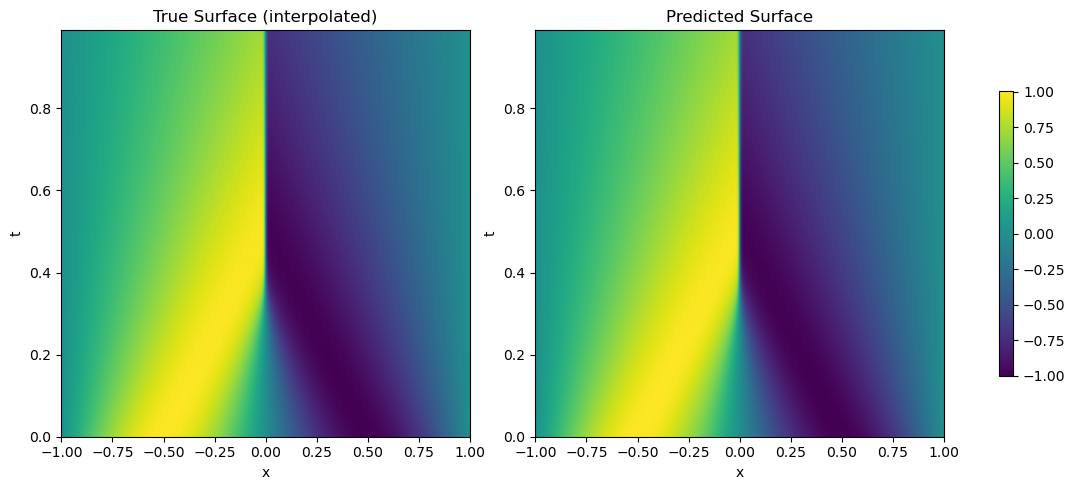

In [20]:
from scipy.interpolate import griddata


n_grid = 1000
x1_min, x1_max = x_tt[:,0].min(), x_tt[:,0].max()
x2_min, x2_max = x_tt[:,1].min(), x_tt[:,1].max()
xx1, xx2 = np.meshgrid(
    np.linspace(x1_min, x1_max, n_grid),
    np.linspace(x2_min, x2_max, n_grid)
)

# flatten grid for prediction
X_grid = jnp.array(np.column_stack([xx1.ravel(), xx2.ravel()]))

# predict on grid via vmap
Y_grid_pred = jax.vmap(u_6000_model)(X_grid)
Y_grid_pred = np.array(Y_grid_pred).reshape(n_grid, n_grid)

# interpolate y_tr to new domain
Y_grid_true = griddata(x_tt, y_tt.flatten(), (xx1, xx2), method='cubic')

# compute max/min for colorbar
vmin = min(np.nanmin(Y_grid_true), np.nanmin(Y_grid_pred))
vmax = max(np.nanmax(Y_grid_true), np.nanmax(Y_grid_pred))

# render heatmaps of soln surface
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(
    Y_grid_true,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin="lower",
    aspect="auto",
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
)
axes[0].set_title("True Surface (interpolated)")
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")

im2 = axes[1].imshow(
    Y_grid_pred,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin="lower",
    aspect="auto",
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
)
axes[1].set_title("Predicted Surface")
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
plt.tight_layout()

fig.colorbar(im1, ax=axes, orientation="vertical", shrink=0.7, location="right")


plt.savefig("sample_pred.png", dpi=300)
plt.show()



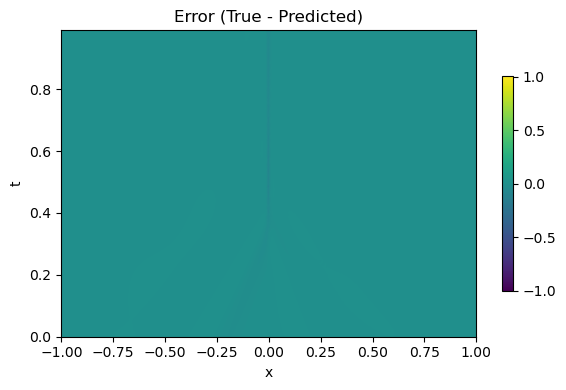

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))

im = ax.imshow(
    (Y_grid_true - Y_grid_pred),
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin="lower",
    aspect="auto",
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
)

ax.set_title("Error (True - Predicted)")
ax.set_xlabel("x")
ax.set_ylabel("t")

plt.colorbar(im, ax=ax, orientation="vertical", shrink=0.7, location="right")

plt.tight_layout()
plt.savefig("sample_pred_error.png", dpi=300)
plt.show()
